# 🔧 Modular Integrated Verification Pipeline

**Complete patch verification with configurable analysis modules:**

## Analysis Modules

1. **Static Analysis** - Code quality (Pylint, Flake8, Radon, Mypy, Bandit)
2. **Dynamic Fuzzing** - Change-aware property-based testing with real coverage
3. **Supplementary Rules** - Targeted bug detection (9 focused verification rules)

## Pipeline Flow

```
Load Patch → Setup Repo → [Static] → [Fuzzing] → [Rules] → Final Verdict
```

Select which modules to enable in the **Configuration** cell below!

## 📝 Configuration

**Enable/disable analysis modules here:**

In [1]:
# ============================================================================
# MODULAR CONFIGURATION
# ============================================================================

ANALYSIS_CONFIG = {
    # Enable/disable analysis modules
    'enable_static': True,      # Static code quality analysis
    'enable_fuzzing': True,     # Dynamic fuzzing with coverage
    'enable_rules': True,       # Supplementary verification rules
    
    # Thresholds
    'static_threshold': 0.5,    # Min SQI score (0-1)
    'coverage_threshold': 0.5,  # Min coverage of changed lines (0-1)
    'rules_fail_on_high_severity': True,  # Reject on high-severity rule findings
    
    # Display options
    'show_detailed_results': True,
    'show_rule_findings': True,
    'show_uncovered_lines': True,
}

# Repository filter
REPO_FILTER = "scikit-learn/scikit-learn"

print("✓ Configuration loaded")
print(f"  Static Analysis: {'✅' if ANALYSIS_CONFIG['enable_static'] else '❌'}")
print(f"  Dynamic Fuzzing: {'✅' if ANALYSIS_CONFIG['enable_fuzzing'] else '❌'}")
print(f"  Verification Rules: {'✅' if ANALYSIS_CONFIG['enable_rules'] else '❌'}")

✓ Configuration loaded
  Static Analysis: ✅
  Dynamic Fuzzing: ✅
  Verification Rules: ✅


## 📦 Imports

In [2]:
import sys, subprocess, os
from pathlib import Path
import json, time, ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

PROJECT_ROOT = Path.cwd()
sys.path.append(str(PROJECT_ROOT))

# Dataset and patch handling
from swebench_integration import DatasetLoader, PatchLoader

# Dynamic container building system
from swebench_singularity import Config, SingularityBuilder, DockerImageResolver

# Analysis modules
from verifier.dynamic_analyzers.patch_analyzer import PatchAnalyzer
from verifier.dynamic_analyzers.test_generator import HypothesisTestGenerator
from verifier.dynamic_analyzers.coverage_analyzer import CoverageAnalyzer
from verifier.dynamic_analyzers.analyze_coverage_unified import analyze_coverage_unified
from verifier.dynamic_analyzers import test_patch_singularity

# Reload to get latest changes
importlib.reload(test_patch_singularity)

from verifier.dynamic_analyzers.test_patch_singularity import (
    install_package_in_singularity, 
    run_tests_in_singularity,
    install_hypothesis_in_singularity,
    install_pytest_cov_in_singularity,
    run_rules_in_singularity,  # NEW: Container-based rules
)

# Static analysis
import streamlit.modules.static_eval.static_modules.code_quality as code_quality
import streamlit.modules.static_eval.static_modules.syntax_structure as syntax_structure
from verifier.utils.diff_utils import parse_unified_diff, filter_paths_to_py

# Verification rules
from verifier.rules import RULE_IDS

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("✓ Imports complete")

/fs/nexus-scratch/ihbas/miniconda3/envs/verifier_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports complete


## 🔧 Container Setup

In [3]:
# Set Apptainer/Singularity environment variables
os.environ["APPTAINER_DOCKER_USERNAME"] = "nacheitor12"
os.environ["APPTAINER_DOCKER_PASSWORD"] = "wN/^4Me%,!5zz_q"
os.environ["SINGULARITY_DOCKER_USERNAME"] = "nacheitor12"
os.environ["SINGULARITY_DOCKER_PASSWORD"] = "wN/^4Me%,!5zz_q"

print("✓ Docker credentials set\n")

# Initialize configuration
config = Config()
config.set("singularity.cache_dir", "/fs/nexus-scratch/ihbas/.cache/swebench_singularity")
config.set("singularity.tmp_dir", "/fs/nexus-scratch/ihbas/.tmp/singularity_build")
config.set("singularity.cache_internal_dir", "/fs/nexus-scratch/ihbas/.singularity/cache")
config.set("singularity.build_timeout", 1800)
config.set("docker.max_retries", 3)
config.set("docker.image_patterns", [
    "swebench/sweb.eval.x86_64.{repo}_1776_{repo}-{version}:latest",
])

builder = SingularityBuilder(config)
resolver = DockerImageResolver(config)

print("✓ Configuration initialized")
print(f"  Singularity: {builder.check_singularity_available()}")

2025-12-02 11:16:43,339 - swebench_singularity.singularity_builder - INFO - Singularity available: apptainer version 1.4.4-1.el8


✓ Docker credentials set

✓ Configuration initialized
  Singularity: True


---
# PATCH LOADING & SETUP
---

## Stage 1: Load Patch

In [4]:
loader = DatasetLoader("princeton-nlp/SWE-bench_Verified", hf_mode=True, split="test")
sample = next(loader.iter_samples(limit=1, filter_repo=REPO_FILTER), None)

if sample:
    instance_id = sample.get('metadata', {}).get('instance_id', 'unknown')
    print(f"✓ {instance_id}")
    print(f"  Repo: {sample['repo']}")
    print(f"\nPatch preview:\n{sample['patch'][:400]}...")
else:
    raise Exception(f"No sample found for {REPO_FILTER}")

✓ scikit-learn__scikit-learn-10297
  Repo: scikit-learn/scikit-learn

Patch preview:
diff --git a/sklearn/linear_model/ridge.py b/sklearn/linear_model/ridge.py
--- a/sklearn/linear_model/ridge.py
+++ b/sklearn/linear_model/ridge.py
@@ -1212,18 +1212,18 @@ class RidgeCV(_BaseRidgeCV, RegressorMixin):
 
     store_cv_values : boolean, default=False
         Flag indicating if the cross-validation values corresponding to
-        each alpha should be stored in the `cv_values_` attrib...


## Stage 2: Setup Repository

In [5]:
patcher = PatchLoader(sample=sample, repos_root="./repos_temp")
repo_path = patcher.clone_repository()
patch_result = patcher.apply_patch()

print(f"✓ Repo: {repo_path}")
print(f"✓ Patch: {'Applied' if patch_result['applied'] else 'FAILED'}")

# Apply test patch
test_patch = sample.get('metadata', {}).get('test_patch', '')
if test_patch and test_patch.strip():
    print("📝 Applying test_patch...")
    try:
        test_patch_result = patcher.apply_additional_patch(test_patch)
        print(f"✓ Test patch applied: {test_patch_result.get('log', 'success')}")
    except Exception as e:
        print(f"⚠️ Test patch application failed: {e}")
else:
    print("ℹ️  No test_patch in metadata")

[+] Cloning scikit-learn/scikit-learn into /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn ...
✓ Repo: /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn
✓ Patch: Applied
📝 Applying test_patch...
✓ Test patch applied: Additional patch applied successfully.


## Stage 3: Build Container

In [6]:
print(f"🐳 Building container for {instance_id}...\n")

docker_image = resolver.find_available_image(instance_id, check_existence=False)
if docker_image:
    print(f"  Docker image: {docker_image.full_name}\n")

build_result = builder.build_instance(
    instance_id=instance_id,
    force_rebuild=False,
    check_docker_exists=False
)

if build_result.success:
    CONTAINER_IMAGE_PATH = build_result.sif_path
    cache_status = "(from cache)" if build_result.from_cache else "(newly built)"
    print(f"✓ Container ready {cache_status}")
    print(f"  Path: {CONTAINER_IMAGE_PATH}")
else:
    raise Exception(f"Container build failed: {build_result.error_message}")

2025-12-02 11:17:15,616 - swebench_singularity.singularity_builder - INFO - Using cached image for scikit-learn__scikit-learn-10297: /fs/nexus-scratch/ihbas/.cache/swebench_singularity/scikit-learn/scikit-learn__scikit-learn-10297.sif


🐳 Building container for scikit-learn__scikit-learn-10297...

  Docker image: docker.io/swebench/sweb.eval.x86_64.scikit-learn_1776_scikit-learn-10297:latest

✓ Container ready (from cache)
  Path: /fs/nexus-scratch/ihbas/.cache/swebench_singularity/scikit-learn/scikit-learn__scikit-learn-10297.sif


## Stage 4: Install Dependencies

In [7]:
print("📦 Installing dependencies...\n")

install_result = install_package_in_singularity(
    repo_path=Path(repo_path),
    image_path=str(CONTAINER_IMAGE_PATH)
)

if install_result.get("installed"):
    print("✓ Dependencies installed")
else:
    print("ℹ️  Using PYTHONPATH mode")

# Install pytest-cov for coverage (Python 3.6 testbed)
if ANALYSIS_CONFIG['enable_fuzzing']:
    print("\n📦 Installing pytest-cov...")
    pytest_cov_result = install_pytest_cov_in_singularity(
        repo_path=Path(repo_path),
        image_path=str(CONTAINER_IMAGE_PATH)
    )
    if pytest_cov_result['installed']:
        print("✓ pytest-cov ready")
    else:
        print("⚠️  pytest-cov installation failed")

# Install scipy for rules in SEPARATE directory (Python 3.11 base)
# This prevents conflicts with testbed Python 3.6 packages
if ANALYSIS_CONFIG['enable_rules']:
    print("\n📦 Installing scipy for rules (separate directory)...")
    
    # Use a separate directory to avoid Python version conflicts
    rules_packages_dir = Path(repo_path) / ".pip_packages_rules"
    rules_packages_dir.mkdir(exist_ok=True)
    
    # Check if scipy is already available
    check_cmd = [
        "singularity", "exec",
        "--bind", f"{str(repo_path)}:/workspace",
        "--env", "PYTHONPATH=/workspace/.pip_packages_rules",
        str(CONTAINER_IMAGE_PATH),
        "/opt/miniconda3/bin/python", "-c",
        "import scipy; print(scipy.__version__)",
    ]
    
    check_proc = subprocess.run(check_cmd, capture_output=True, text=True, timeout=10)
    
    if check_proc.returncode == 0:
        version = check_proc.stdout.strip()
        print(f"✓ scipy already available (version {version})")
    else:
        # Install scipy for base Python 3.11
        install_cmd = [
            "singularity", "exec",
            "--bind", f"{str(repo_path)}:/workspace",
            str(CONTAINER_IMAGE_PATH),
            "/opt/miniconda3/bin/pip", "install",
            "--target", "/workspace/.pip_packages_rules",
            "--no-cache-dir", "--quiet",
            "scipy", "numpy",
        ]
        
        install_proc = subprocess.run(install_cmd, capture_output=True, text=True, timeout=180)
        
        if install_proc.returncode == 0:
            print("✓ scipy installed successfully to .pip_packages_rules/")
        else:
            print(f"⚠️  scipy installation failed")
            print(f"   Error: {install_proc.stderr[:200]}")

📦 Installing dependencies...

📦 Preparing package for testing in: /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn
   Setup files found: setup.py=True, pyproject.toml=False, setup.cfg=True
   Copying pre-built C extensions from container...
✅ Successfully copied 40 pre-built C extension files
✓ Dependencies installed

📦 Installing pytest-cov...
📦 Installing pytest-cov to /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn/.pip_packages...
✅ pytest-cov installed successfully to .pip_packages/
✓ pytest-cov ready

📦 Installing scipy for rules (separate directory)...
✓ scipy installed successfully to .pip_packages_rules/


---
# MODULE 1: STATIC ANALYSIS
---

In [8]:
if ANALYSIS_CONFIG['enable_static']:
    print("="*80)
    print("MODULE 1: STATIC ANALYSIS")
    print("="*80)
    
    static_config = {
        'checks': {'pylint': True, 'flake8': True, 'radon': True, 'mypy': True, 'bandit': True},
        'weights': {'pylint': 0.5, 'flake8': 0.15, 'radon': 0.25, 'mypy': 0.05, 'bandit': 0.05}
    }
    
    print("\n🔍 Running static analysis...")
    cq_results = code_quality.analyze(str(repo_path), sample['patch'], static_config)
    ss_results = syntax_structure.run_syntax_structure_analysis(str(repo_path), sample['patch'])
    
    sqi_data = cq_results.get('sqi', {})
    sqi_score = sqi_data.get('SQI', 0) / 100.0
    
    print(f"\n✓ SQI: {sqi_data.get('SQI', 0)}/100 ({sqi_data.get('classification', 'Unknown')})")
    
    if ANALYSIS_CONFIG['show_detailed_results']:
        print(f"\n  Details:")
        for tool, data in cq_results.get('tools', {}).items():
            score = data.get('score', 0)
            print(f"    {tool}: {score:.1f}/100")
    
    # Check threshold
    if sqi_score < ANALYSIS_CONFIG['static_threshold']:
        print(f"\n❌ FAILED: SQI below threshold ({sqi_score:.2f} < {ANALYSIS_CONFIG['static_threshold']})")
        static_passed = False
    else:
        print(f"\n✅ PASSED: SQI meets threshold")
        static_passed = True
else:
    print("⏭️  Static analysis skipped (disabled)")
    sqi_score = 0.0
    sqi_data = {}
    static_passed = True  # Don't fail if disabled

MODULE 1: STATIC ANALYSIS

🔍 Running static analysis...

✓ SQI: 62.14/100 (Fair)

  Details:

✅ PASSED: SQI meets threshold


---
# MODULE 2: DYNAMIC FUZZING
---

## Step 1: Analyze Patch

In [9]:
if ANALYSIS_CONFIG['enable_fuzzing']:
    print("="*80)
    print("MODULE 2: DYNAMIC FUZZING")
    print("="*80)
    
    print("\n🔍 Analyzing patch...")
    
    patch_analyzer = PatchAnalyzer()
    parsed_diff = parse_unified_diff(sample['patch'])
    modified_files = filter_paths_to_py(list(parsed_diff.keys()))
    
    if modified_files:
        first_file_path = modified_files[0]
        first_file = Path(repo_path) / first_file_path
        patched_code = first_file.read_text(encoding='utf-8')
        
        patch_analysis = patch_analyzer.parse_patch(sample['patch'], patched_code, file_path=first_file_path)
        
        print(f"\n✓ Analysis complete:")
        print(f"  Files: {len(modified_files)}")
        print(f"  Module: {patch_analysis.module_path}")
        print(f"  Functions: {patch_analysis.changed_functions}")
        if patch_analysis.class_context:
            print(f"  Classes: {list(patch_analysis.class_context.values())}")
        print(f"  Changed lines: {len(patch_analysis.all_changed_lines)}")
        
        coverage_source = patch_analysis.module_path.split('.')[0]
    else:
        patch_analysis = None
        patched_code = None
        coverage_source = None
        print("⚠️ No Python files modified")
else:
    print("⏭️  Dynamic fuzzing skipped (disabled)")
    patch_analysis = None
    patched_code = None
    coverage_source = None

MODULE 2: DYNAMIC FUZZING

🔍 Analyzing patch...

✓ Analysis complete:
  Files: 1
  Module: sklearn.linear_model.ridge
  Functions: ['__init__']
  Classes: ['RidgeClassifierCV']
  Changed lines: 20


## Step 2: Run Baseline Tests (with coverage)

In [10]:
if ANALYSIS_CONFIG['enable_fuzzing'] and patch_analysis:
    print("\n🧪 Running baseline tests...\n")
    
    fail_to_pass = sample.get('metadata', {}).get('FAIL_TO_PASS', '[]')
    pass_to_pass = sample.get('metadata', {}).get('PASS_TO_PASS', '[]')
    
    try:
        f2p = ast.literal_eval(fail_to_pass) if isinstance(fail_to_pass, str) else fail_to_pass
        p2p = ast.literal_eval(pass_to_pass) if isinstance(pass_to_pass, str) else pass_to_pass
    except:
        f2p, p2p = [], []
    
    all_tests = f2p + p2p
    
    test_result = run_tests_in_singularity(
        repo_path=Path(repo_path),
        tests=all_tests,
        image_path=str(CONTAINER_IMAGE_PATH),
        collect_coverage=True,
        coverage_source=coverage_source,
    )
    
    existing_tests_pass = (test_result['returncode'] == 0)
    print(f"\n{'✓' if existing_tests_pass else '⚠️'} Tests {'passed' if existing_tests_pass else 'had issues'}")
    
    # Analyze baseline coverage
    if 'coverage_file' in test_result and test_result['coverage_file']:
        baseline_cov_file = Path(test_result['coverage_file'])
        
        if baseline_cov_file.exists():
            baseline_coverage_data = json.loads(baseline_cov_file.read_text())
            analyzer = CoverageAnalyzer()
            
            baseline_analysis = analyze_coverage_unified(
                coverage_data=baseline_coverage_data,
                patch_analysis=patch_analysis,
                analyzer=analyzer,
                label="BASELINE"
            )
            
            if baseline_analysis:
                baseline_coverage = baseline_analysis['line_coverage']
                baseline_covered_lines = baseline_analysis['covered_lines']
                baseline_branch_coverage = baseline_analysis['branch_coverage']
            else:
                baseline_coverage = 0.0
                baseline_covered_lines = set()
                baseline_branch_coverage = 0.0
        else:
            baseline_coverage = 0.0
            baseline_covered_lines = set()
            baseline_branch_coverage = 0.0
    else:
        baseline_coverage = 0.0
        baseline_covered_lines = set()
        baseline_branch_coverage = 0.0
else:
    existing_tests_pass = True
    baseline_coverage = 0.0
    baseline_covered_lines = set()
    baseline_branch_coverage = 0.0


🧪 Running baseline tests...

ℹ️  Using existing C extensions (176 files)
📊 Coverage collection enabled for: sklearn (with branch coverage)
🧪 Running tests in Singularity:
  singularity exec --bind /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn:/workspace --pwd /workspace --env PYTHONPATH=/workspace/.pip_packages:/workspace /fs/nexus-scratch/ihbas/.cache/swebench_singularity/scikit-learn/scikit-learn__scikit-learn-10297.sif /opt/miniconda3/envs/testbed/bin/python -m pytest -q --cov=sklearn --cov-branch --cov-report=term-missing:skip-covered sklearn/linear_model/tests/test_ridge.py::test_ridge_classifier_cv_store_cv_values sklearn/linear_model/tests/test_ridge.py::test_ridge sklearn/linear_model/tests/test_ridge.py::test_primal_dual_relationship sklearn/linear_model/tests/test_ridge.py::test_ridge_singular sklearn/linear_model/tests/test_ridge.py::test_ridge_regression_sample_weights sklearn/linear_model/tests/test_ridge.py::test_ridge_sample_weights skle

## Step 3: Generate & Run Fuzzing Tests

In [11]:
if ANALYSIS_CONFIG['enable_fuzzing'] and patch_analysis and patch_analysis.changed_functions:
    print("\n🧬 Generating fuzzing tests...\n")
    
    test_generator = HypothesisTestGenerator(repo_path=Path(repo_path))
    test_code = test_generator.generate_tests(patch_analysis, patched_code)
    test_count = test_code.count('def test_')
    
    test_file = Path(repo_path) / "test_fuzzing_generated.py"
    test_file.write_text(test_code, encoding='utf-8')
    
    print(f"✓ Generated {test_count} tests")
    
    # Install hypothesis
    print("\n📦 Installing hypothesis...")
    hypothesis_install = install_hypothesis_in_singularity(
        repo_path=Path(repo_path),
        image_path=str(CONTAINER_IMAGE_PATH)
    )
    
    # Preserve baseline coverage
    baseline_cov_json = Path(repo_path) / ".coverage.json"
    if baseline_cov_json.exists():
        baseline_cov_json.rename(Path(repo_path) / ".coverage.baseline.json")
    
    baseline_cov_db = Path(repo_path) / ".coverage"
    if baseline_cov_db.exists():
        baseline_cov_db.unlink()
    
    print("\n🐳 Executing fuzzing tests...\n")
    
    fuzzing_result = run_tests_in_singularity(
        repo_path=Path(repo_path),
        tests=["test_fuzzing_generated.py"],
        image_path=str(CONTAINER_IMAGE_PATH),
        extra_env={"HYPOTHESIS_MAX_EXAMPLES": "50"},
        collect_coverage=True,
        coverage_source=coverage_source,
    )
    
    fuzzing_success = (fuzzing_result['returncode'] == 0)
    print(f"\n{'✓' if fuzzing_success else '⚠️'} Fuzzing tests {'passed' if fuzzing_success else 'had issues'}")
    
    # Analyze fuzzing coverage
    if 'coverage_file' in fuzzing_result and fuzzing_result['coverage_file']:
        fuzzing_cov_file = Path(fuzzing_result['coverage_file'])
        
        if fuzzing_cov_file.exists():
            fuzzing_coverage_data = json.loads(fuzzing_cov_file.read_text())
            
            fuzzing_analysis = analyze_coverage_unified(
                coverage_data=fuzzing_coverage_data,
                patch_analysis=patch_analysis,
                analyzer=CoverageAnalyzer(),
                label="FUZZING"
            )
            
            if fuzzing_analysis:
                fuzzing_only_covered = fuzzing_analysis['covered_lines']
                fuzzing_branch_coverage = fuzzing_analysis['branch_coverage']
                
                # Combine baseline + fuzzing
                combined_covered_lines = baseline_covered_lines | fuzzing_only_covered
                all_changed = set(patch_analysis.all_changed_lines)
                combined_uncovered_lines = sorted(list(all_changed - combined_covered_lines))
                combined_coverage = len(combined_covered_lines) / len(all_changed) if all_changed else 0.0
                combined_branch_coverage = max(baseline_branch_coverage, fuzzing_branch_coverage)
                
                print(f"\n📊 COMBINED COVERAGE:")
                print(f"   Line: {combined_coverage*100:.1f}%")
                print(f"   Covered: {len(combined_covered_lines)}/{len(all_changed)} lines")
                if ANALYSIS_CONFIG['show_uncovered_lines'] and combined_uncovered_lines:
                    print(f"   Uncovered: {combined_uncovered_lines[:10]}...")
            else:
                combined_coverage = baseline_coverage
                combined_covered_lines = baseline_covered_lines
                combined_uncovered_lines = sorted(list(set(patch_analysis.all_changed_lines) - baseline_covered_lines))
                combined_branch_coverage = baseline_branch_coverage
        else:
            combined_coverage = baseline_coverage
            combined_covered_lines = baseline_covered_lines
            combined_uncovered_lines = sorted(list(set(patch_analysis.all_changed_lines) - baseline_covered_lines))
            combined_branch_coverage = baseline_branch_coverage
    else:
        combined_coverage = baseline_coverage
        combined_covered_lines = baseline_covered_lines
        combined_uncovered_lines = sorted(list(set(patch_analysis.all_changed_lines) - baseline_covered_lines))
        combined_branch_coverage = baseline_branch_coverage
    
    # Check threshold
    if combined_coverage < ANALYSIS_CONFIG['coverage_threshold']:
        print(f"\n⚠️  WARNING: Coverage below threshold ({combined_coverage:.2f} < {ANALYSIS_CONFIG['coverage_threshold']})")
        fuzzing_passed = False
    else:
        print(f"\n✅ Coverage meets threshold")
        fuzzing_passed = True
        
else:
    fuzzing_success = True
    combined_coverage = baseline_coverage
    combined_covered_lines = baseline_covered_lines
    combined_uncovered_lines = []
    combined_branch_coverage = 0.0
    fuzzing_passed = True
    test_count = 0


🧬 Generating fuzzing tests...

✓ Generated 1 tests

📦 Installing hypothesis...
📦 Installing hypothesis to /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn/.pip_packages...
✅ Hypothesis installed successfully to .pip_packages/

🐳 Executing fuzzing tests...

ℹ️  Using existing C extensions (176 files)
📊 Coverage collection enabled for: sklearn (with branch coverage)
🧪 Running tests in Singularity:
  singularity exec --bind /fs/nexus-scratch/ihbas/verifier_harness/repos_temp/scikit-learn__scikit-learn:/workspace --pwd /workspace --env PYTHONPATH=/workspace/.pip_packages:/workspace --env HYPOTHESIS_MAX_EXAMPLES=50 /fs/nexus-scratch/ihbas/.cache/swebench_singularity/scikit-learn/scikit-learn__scikit-learn-10297.sif /opt/miniconda3/envs/testbed/bin/python -m pytest -q --cov=sklearn --cov-branch --cov-report=term-missing:skip-covered test_fuzzing_generated.py

✓ Coverage data saved to: .coverage.json

✓ Fuzzing tests passed

📊 FUZZING COVERAGE:
   Line coverage:

---
# MODULE 3: SUPPLEMENTARY RULES
---

In [12]:
  # Force reload the updated module
  import importlib
  importlib.reload(test_patch_singularity)

  # Re-import the function
  from verifier.dynamic_analyzers.test_patch_singularity import (
      install_package_in_singularity,
      run_tests_in_singularity,
      install_hypothesis_in_singularity,
      install_pytest_cov_in_singularity,
      run_rules_in_singularity,  # This is the new function
  )

  print("✓ Module reloaded with updated code")


✓ Module reloaded with updated code


In [13]:
if ANALYSIS_CONFIG['enable_rules']:
    print("="*80)
    print("MODULE 3: SUPPLEMENTARY VERIFICATION RULES")
    print("="*80)
    
    print(f"\n🔍 Running {len(RULE_IDS)} verification rules...\n")
    
    try:
        # NEW: Run rules inside the container where sklearn can be properly loaded
        rules_result = run_rules_in_singularity(
            repo_path=Path(repo_path),
            patch_str=sample['patch'],
            rule_ids=RULE_IDS,
            image_path=str(CONTAINER_IMAGE_PATH),
            verifier_harness_path=Path.cwd(),
        )
        
        # Parse results from JSON output
        if 'results' in rules_result and rules_result['results']:
            rules_results = rules_result['results']
            
            # Aggregate findings
            all_findings = []
            failed_rules = []
            
            for result in rules_results:
                if result.get('status') == 'failed':
                    failed_rules.append(result.get('name', 'unknown'))
                    all_findings.extend(result.get('findings', []))
            
            print(f"✓ Rules execution complete")
            print(f"  Total rules: {len(rules_results)}")
            print(f"  Passed: {len(rules_results) - len(failed_rules)}")
            print(f"  Failed: {len(failed_rules)}")
            print(f"  Findings: {len(all_findings)}")
            
            # Count severity
            high_severity_count = sum(1 for f in all_findings if f.get('severity') == 'high')
            
            if ANALYSIS_CONFIG['show_rule_findings'] and all_findings:
                print(f"\n  Findings by severity:")
                print(f"    High: {high_severity_count}")
                print(f"    Medium: {sum(1 for f in all_findings if f.get('severity') == 'medium')}")
                print(f"    Low: {sum(1 for f in all_findings if f.get('severity') == 'low')}")
                
                print(f"\n  Sample findings:")
                for finding in all_findings[:5]:
                    severity_icon = '🔴' if finding['severity'] == 'high' else '🟡' if finding['severity'] == 'medium' else '🟢'
                    desc = finding['description'][:80]
                    loc = finding.get('location', 'N/A')
                    print(f"    {severity_icon} {desc}... ({loc})")
                
                if len(all_findings) > 5:
                    print(f"    ... and {len(all_findings) - 5} more")
            
            # Check if failed
            if high_severity_count > 0 and ANALYSIS_CONFIG['rules_fail_on_high_severity']:
                print(f"\n❌ FAILED: {high_severity_count} high-severity finding(s)")
                rules_passed = False
            elif len(failed_rules) > 0:
                print(f"\n⚠️  WARNING: {len(failed_rules)} rule(s) found issues")
                rules_passed = True  # Warning, not failure
            else:
                print(f"\n✅ PASSED: All rules passed")
                rules_passed = True
        else:
            # No results returned
            print(f"⚠️  No rules results returned")
            if rules_result.get('stderr'):
                print(f"   Error: {rules_result['stderr'][:400]}")
            rules_results = []
            failed_rules = []
            all_findings = []
            high_severity_count = 0
            rules_passed = True  # Don't fail on error
            
    except Exception as e:
        import traceback
        print(f"\n⚠️ Rules execution error: {e}")
        print(f"\nFull traceback:")
        traceback.print_exc()
        rules_results = []
        failed_rules = []
        all_findings = []
        high_severity_count = 0
        rules_passed = True  # Don't fail on error
        
else:
    print("⏭️  Supplementary rules skipped (disabled)")
    rules_results = []
    failed_rules = []
    all_findings = []
    high_severity_count = 0
    rules_passed = True

MODULE 3: SUPPLEMENTARY VERIFICATION RULES

🔍 Running 9 verification rules...

🔍 Running rules in Singularity container...
  Rules: all
  Repo: scikit-learn__scikit-learn
✓ Rules executed successfully: 9 rule(s) ran
✓ Rules execution complete
  Total rules: 9
  Passed: 9
  Failed: 0
  Findings: 0

✅ PASSED: All rules passed


---
# FINAL VERDICT
---

In [14]:
print("\n" + "="*80)
print("FINAL VERDICT")
print("="*80)

# Calculate overall score
weights = {
    'static': 30 if ANALYSIS_CONFIG['enable_static'] else 0,
    'tests': 40,
    'fuzzing': 15 if ANALYSIS_CONFIG['enable_fuzzing'] else 0,
    'coverage': 10 if ANALYSIS_CONFIG['enable_fuzzing'] else 0,
    'branch': 5 if ANALYSIS_CONFIG['enable_fuzzing'] else 0,
}

# Normalize weights to sum to 100
total_weight = sum(weights.values())
for key in weights:
    weights[key] = (weights[key] / total_weight) * 100

overall_score = (
    (sqi_score * 100 if ANALYSIS_CONFIG['enable_static'] else 0) * (weights['static'] / 100) +
    (100 if existing_tests_pass else 0) * (weights['tests'] / 100) +
    (100 if fuzzing_success else 0) * (weights['fuzzing'] / 100) +
    (combined_coverage * 100 if ANALYSIS_CONFIG['enable_fuzzing'] else 0) * (weights['coverage'] / 100) +
    (combined_branch_coverage * 100 if ANALYSIS_CONFIG['enable_fuzzing'] else 0) * (weights['branch'] / 100)
)

# Determine verdict
failed_checks = []
if not static_passed:
    failed_checks.append("Static analysis")
if not existing_tests_pass:
    failed_checks.append("Existing tests")
if not fuzzing_success:
    failed_checks.append("Fuzzing tests")
if not fuzzing_passed:
    failed_checks.append("Coverage threshold")
if not rules_passed:
    failed_checks.append("Verification rules")

if failed_checks:
    if any(c in failed_checks for c in ["Static analysis", "Existing tests", "Verification rules"]):
        verdict = "❌ REJECT"
        reason = f"Failed: {', '.join(failed_checks)}"
    else:
        verdict = "⚠️  WARNING"
        reason = f"Warnings: {', '.join(failed_checks)}"
else:
    if overall_score >= 80:
        verdict = "✅ EXCELLENT"
        reason = "All checks passed with high score"
    elif overall_score >= 60:
        verdict = "✓ GOOD"
        reason = "All checks passed"
    else:
        verdict = "⚠️  FAIR"
        reason = "Passed but with low overall score"

print(f"\nInstance: {instance_id}")
print(f"Overall Score: {overall_score:.1f}/100")
print(f"Verdict: {verdict}")
print(f"Reason: {reason}\n")

print("Component Results:")
if ANALYSIS_CONFIG['enable_static']:
    print(f"  Static Analysis: {sqi_score*100:.1f}/100 {'✅' if static_passed else '❌'}")
print(f"  Existing Tests: {'PASS ✅' if existing_tests_pass else 'FAIL ❌'}")
if ANALYSIS_CONFIG['enable_fuzzing']:
    print(f"  Fuzzing Tests: {'PASS ✅' if fuzzing_success else 'FAIL ❌'} ({test_count} generated)")
    print(f"  Coverage: {combined_coverage*100:.1f}% {'✅' if fuzzing_passed else '⚠️'}")
if ANALYSIS_CONFIG['enable_rules']:
    print(f"  Verification Rules: {len(rules_results) - len(failed_rules)}/{len(rules_results)} passed {'✅' if rules_passed else '❌'}")
    if high_severity_count > 0:
        print(f"    ⚠️  {high_severity_count} high-severity finding(s)")

# Save results
results = {
    'instance_id': instance_id,
    'overall_score': overall_score,
    'verdict': verdict,
    'reason': reason,
    'enabled_modules': {
        'static': ANALYSIS_CONFIG['enable_static'],
        'fuzzing': ANALYSIS_CONFIG['enable_fuzzing'],
        'rules': ANALYSIS_CONFIG['enable_rules'],
    },
    'static': {
        'sqi_score': sqi_score * 100,
        'passed': static_passed
    } if ANALYSIS_CONFIG['enable_static'] else None,
    'fuzzing': {
        'tests_passed': existing_tests_pass,
        'fuzzing_passed': fuzzing_success,
        'tests_generated': test_count,
        'combined_coverage': combined_coverage * 100,
        'baseline_coverage': baseline_coverage * 100,
        'improvement': (combined_coverage - baseline_coverage) * 100,
        'passed': fuzzing_passed
    } if ANALYSIS_CONFIG['enable_fuzzing'] else None,
    'rules': {
        'total_rules': len(rules_results),
        'failed_rules': len(failed_rules),
        'findings_count': len(all_findings),
        'high_severity_count': high_severity_count,
        'passed': rules_passed
    } if ANALYSIS_CONFIG['enable_rules'] else None,
}

with open('integrated_pipeline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n💾 Results saved to integrated_pipeline_results.json")
print("="*80)


FINAL VERDICT

Instance: scikit-learn__scikit-learn-10297
Overall Score: 80.6/100
Verdict: ⚠️  WARNING
Reason: Warnings: Coverage threshold

Component Results:
  Static Analysis: 62.1/100 ✅
  Existing Tests: PASS ✅
  Fuzzing Tests: PASS ✅ (1 generated)
  Coverage: 20.0% ⚠️
  Verification Rules: 9/9 passed ✅

💾 Results saved to integrated_pipeline_results.json


## 📊 Visualization

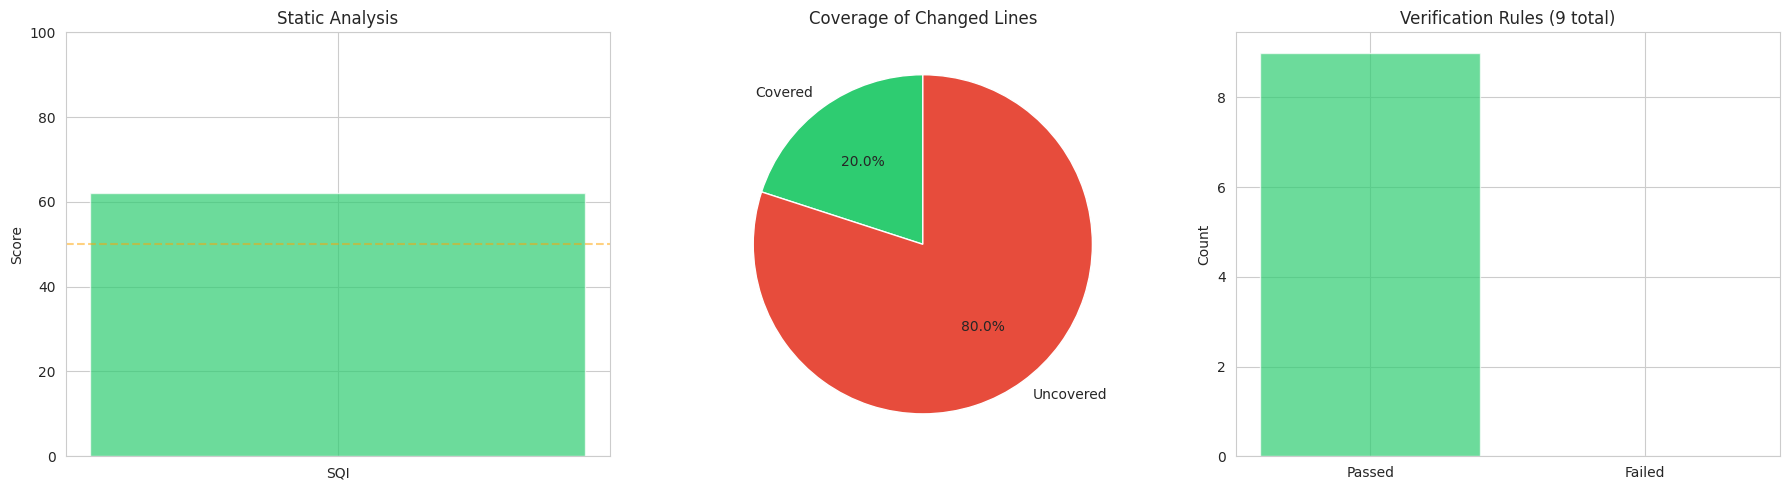

✓ Visualization saved to integrated_pipeline_viz.png


In [15]:
# Create visualization
modules_enabled = sum([ANALYSIS_CONFIG['enable_static'], ANALYSIS_CONFIG['enable_fuzzing'], ANALYSIS_CONFIG['enable_rules']])

if modules_enabled > 1:
    fig, axes = plt.subplots(1, min(3, modules_enabled), figsize=(6*min(3, modules_enabled), 5))
    if modules_enabled == 1:
        axes = [axes]
    
    ax_idx = 0
    
    # Static analysis
    if ANALYSIS_CONFIG['enable_static'] and ax_idx < len(axes):
        ax = axes[ax_idx]
        color = '#2ecc71' if static_passed else '#e74c3c'
        ax.bar(['SQI'], [sqi_score * 100], color=color, alpha=0.7)
        ax.set_ylim(0, 100)
        ax.set_ylabel('Score')
        ax.set_title('Static Analysis')
        ax.axhline(y=ANALYSIS_CONFIG['static_threshold'] * 100, color='orange', linestyle='--', alpha=0.5)
        ax_idx += 1
    
    # Coverage
    if ANALYSIS_CONFIG['enable_fuzzing'] and ax_idx < len(axes):
        ax = axes[ax_idx]
        ax.pie([combined_coverage * 100, (1 - combined_coverage) * 100],
               labels=['Covered', 'Uncovered'],
               colors=['#2ecc71', '#e74c3c'],
               autopct='%1.1f%%',
               startangle=90)
        ax.set_title('Coverage of Changed Lines')
        ax_idx += 1
    
    # Rules
    if ANALYSIS_CONFIG['enable_rules'] and ax_idx < len(axes):
        ax = axes[ax_idx]
        passed_count = len(rules_results) - len(failed_rules)
        ax.bar(['Passed', 'Failed'], [passed_count, len(failed_rules)],
               color=['#2ecc71', '#e74c3c'], alpha=0.7)
        ax.set_ylabel('Count')
        ax.set_title(f'Verification Rules ({len(rules_results)} total)')
        ax_idx += 1
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_viz.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualization saved to integrated_pipeline_viz.png")
else:
    print("ℹ️  Visualization skipped (need at least 2 modules enabled)")